In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif # # 이산적인 목표 변수에 대한 상호 정보를 추정
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/porto-seguro-safe-driver-prediction/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows,columns))

The train dataset contains 595212 rows and 59 columns


# 1. Data Quality checks

## 1-1. Null or Missing values check
As part of out quality checks, let us quick look at whether there are any null values in the train dataset as follows

In [4]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

Null 값 검사는 False를 반환하지만, 이는 데이터가 -1값은 관측값에서 해당 feature이 누락되었음을 나타낸다고 설명되어 있기 때문에 실제로 Null 값이 없다고 반환하는 것이 아님.

단순히 데이터의 모든 Null값을 -1값으로 일괄교체 했다고 생각됨.

데이터에 누락된 값이 있는지 확인..

In [5]:
# -1값을 Null값으로 대체
train_copy = train
train_copy = train_copy.replace(-1, np.NAN)

데이터셋에서 누락된 값을 시각화하는 데 가장 유용하고 편리한 도구인 "missingno"패키지

<Axes: >

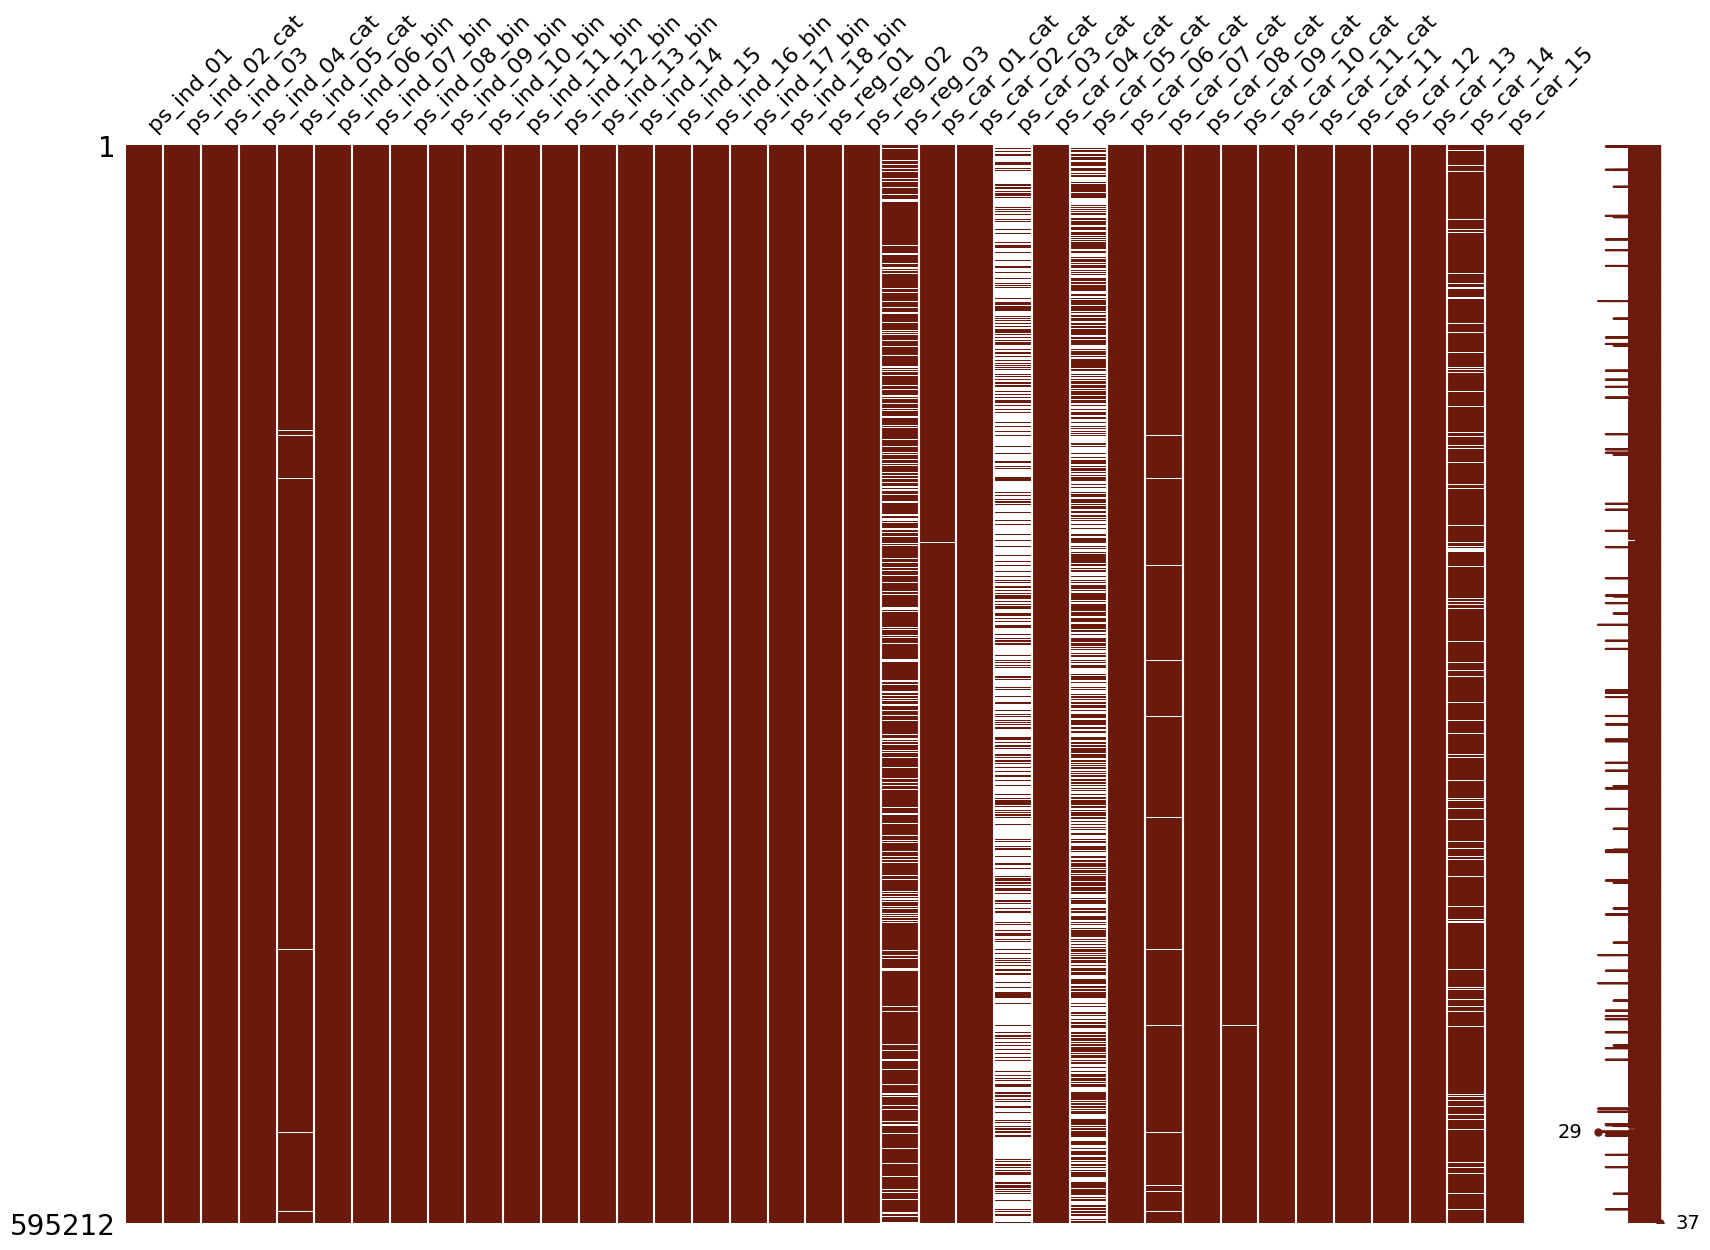

In [6]:
import missingno as msno

# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39],figsize=(20,14),color=(0.42,0.1,0.05))

결측값은 시각화할 때 훨씬 더 명확해짐.

빈 흰색 띠(결측된 데이터)가 수직의 어두운 빨간색 띠(결측되지 않은 데이터)에 겹쳐져 해당열의 데이터가 무효임을 나타냄.

이 경우 59개의 feature중 7개의 feature이 실제로 무효값을 포함하고 있음을 알 수 있음.

(결측값이 있는 열은 총 13개로 구성)

이는 결측 행렬 플롯이 하나의 플롯에 약 40개의 홀수 feature만 편안하게 맞출 수 있고,

그 후 일부 열이 제외되어 나머지 5개의 무효열이 제외되었기 때문.

모든 무효값을 시각화하려면 그림 크기 인수를 변경하고 데이터 프레임을 슬라이스하는 방법을 조정해야함.



우리가 관찰할 수 있는 7개의 Null 열은 다음과 같음. :

**ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14**

대부분의 결측값은 _cat으로 둘러싸인 열에서 발생.

ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에 대해 더 주목해야함.

흰색과 어두운 띠의 비율에서 알 수 있듯 이 세열에서 대부분의 값이 결측된 것이 분명하므로,

널에 대해 -1을 일괄적으로 대체하는 것은 그다지 좋은 전략이 아닐 수 있음.

## 1-2. Target variable inspection

데이터에 대해 일반적으로 수행되는 또 다른 표준 검사는 목표 변수와 관련된 것.

이 경우 열은 편리하게 "target"이라는 제목으로 불림. 목표값은 class/label/correct answer라는 이름으로도 불리며,

지도 학습 모델에서 주어진 데이터와 함께 사용되어 학습된 함수가 새로운 미지의 데이터로 잘 일반화되고 예측할 수 있기를 바라며

데이터를 목표에 가장 잘 매핑하는 함수를 학습하는 데 사용.

In [7]:
data = [go.Bar(
    x = train["target"].value_counts().index.values,
    y = train["target"].value_counts().values,
    text = 'Distribution of target variable'
)]

layout = go.Layout(
    title = 'Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='basic-bar')
fig.show(renderer='iframe') # 이거 추가하니까 그려짐..

목표 변수가 다소 불균형적이기 때문에 염두에 두어야 할 사항일 수 있음.
불균형한 target은 꽤 잘 드러날 것임.

## 1-3. Datatype check

이 검사는 train데이터가 어떤 종류의 데이터 유형으로 구성되어 있는지 확인하기 위해 수행.

integer, character, float, python시퀀스에서 고유한 유형의 카운틀를 얻는 요령은 다음과 같이 컬렉션 모듈을 가져올 때 카운터 메서드를 사용하는 것.

In [8]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

위에서 언급한 바와 같이, train 데이터셋을 구성하는 열은 총 59개이며, 이 검사에서 볼 수 있듯

feature/columns는 정수형과 실수형 두가지 데이터 유형으로만 구성되어 있음.

또 다른 주목할 점은 데이터 제공자가 실제로 "_bin", "_cat", "_reg"와 같은 약어로 둘러싸인 헤더를 제공했다는 점.

여기서 _bin은 binary 이진 feature을 나타내고, _cat은 category 범주형 feature를 나타내며,

나머지는 연속형 혹은 순서형 feature를 나타낸다는 설명을 제공했음.

여기서는 float값(아마도 연속형 feature만)과 integer 데이터 유형(이진형, 범주형 및 순서형 feature)만 살펴보는 것으로 이를 좀 더 단순화 함.

In [9]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

# 2. Correlation plots

우선 함수가 다음 함수와 어떻게 선형적으로 상관되는지 살펴보고, 여기서 통찰력을 얻기 위해 선형 상관관계 그래프를 생성해 보도록 함.

Seaborn을 사용하여 상관관계 히트맵을 그림.

## 2-1. Correlation of float features

<Axes: title={'center': 'Pearson corelation of continuous features'}>

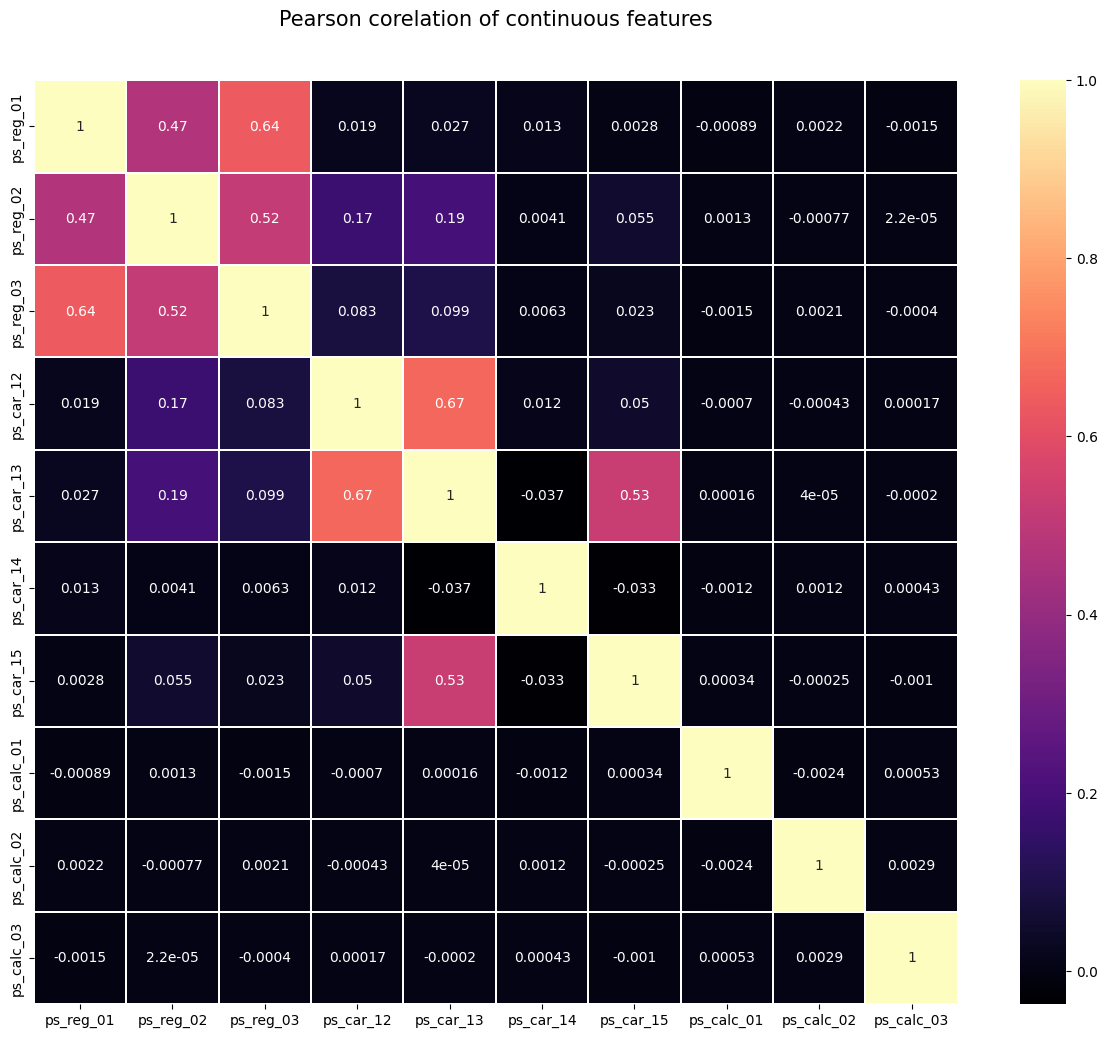

In [10]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson corelation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1,  vmax=1.0, square=True,
           cmap=colormap, linecolor='white', annot=True)

상관관계 그래프에서 대부분의 feature가 서로 상관관계가 없거나 전혀 없음을 알 수 있음.

현재로서는 양의 선형관계를 나타내는 쌍을 이루는 feature는 다음과 같음.


**(ps_reg_01, ps_reg_03)**

**(ps_reg_02, ps_reg_03)**

**(ps_car_12, ps_car_13)**

**(ps_car_13, ps_car_15)**


## 2-2. Correlation of integer features

plotly 라이브러리를 사용하여 상호작용적으로 상관관계 값의 히트맵을 생성하는 방법.

이전 plotly 플롯과 마찬가지로 "go.Heatmap"을 호출하여, 히트맵 객체를 생성.

여기서 우리는 x축과 y축이 열 이름을 입력하고 상관관계 값은 z축이 제공하는 세가지 축에 값을 제공해야 함.

colorsclae속성은 히트맵에서도 볼 수 있는 다양한 색상 팔레트에 해당하는 키워드를 입력받음.

In [11]:
data = [
    go.Heatmap(
        z = train_int.corr().values,
        x = train_int.columns.values,
        y = train_int.columns.values,
        colorscale = 'Viridis',
        reversescale = False,
        # text = True,
        opacity = 1.0
    )
]

layout = go.Layout(
    title='Pearson correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks=''),
    width = 900, height=700
)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='iframe')

마찬가지로 상관관계 플롯에서 0값 셀을 꽤 많이 관찰한다는 사실에서 볼 수 있듯 서로 선형적으로 상관관계가 없는 열이 매우 많다는 것을 알 수 있음.

이는 특히 주성분분석 (PCA)과 같은 차원 축소 변환을 수행하려면 어느 정도의 상관관계가 필요함.

음의 상관관계가 있는 특징 :
(ps_ind_06_bin, ps_ind_07, ps_ind_08_bin, ps_ind_09_bin)

주목할만한 측면 중 하나는 이전의 무효성 분석에서 ps_car_03_cat와 ps_car_05_cat가 많은 결측값 또는 무효값을 포함하고 있다는 것.

따라서 이 두가지의 특징이 서로 매우 강한 양의 선형 상관관계를 보이는 것은 놀라운 일이 아니지만, 데이터의 근본적인 진실을 제대로 반영하지 못할 수도 있음.

# 3. Mutual Information plots
상호 정보는 대상 변수와 계산된 해당 특징 간의 상호 정보를 검사할 수 있게 해주는 또 다른 유용한 도구.

분류 문제의 경우. 두 무작위 변수 간의 의존성을 측정하는 skelarn의 mutual_info_classif 방법을 편리하게 호출할 수 있으며,

이 방법은 0(랜덤 변수가 서로 독립적인 경우)부터 더 높은 값(어느 정도의 의존성을 나타냄)까지 다양함.

따라서 이 방법은 대상 변수의 정보가 특징 내에 얼마나 포함 될 수 있는지 파악하는데 도움이 됨.

In [12]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors = 3, random_state=17)
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


# 4. Binary features inspection

데이터의 또다른 측면은 이진 값만 포함된 열, 즉 값이 1또는 0 중 하나만 차지하는 열일 수 있음.

계속 진행하여 이러한 이진 값을 포함하는 모든 열을 저장한 다음

다음과 같이 이진 값의 수직 플롯 막대 그래프를 생성함.

In [13]:
bin_col = [col for col in train.columns if '_bin' in col]

print(f'bin_col : {bin_col}')

bin_zero_list = []
bin_one_list = []

for col in bin_col:
    bin_zero_list.append((train[col]==0).sum())
    bin_one_list.append((train[col]==1).sum())

print(f'bin_zero_list : {bin_zero_list}')
print(f'bin_one_list : {bin_one_list}')

bin_col : ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
bin_zero_list : [360852, 442223, 497644, 484917, 594990, 594205, 589594, 594648, 201882, 523143, 503879, 522342, 221514, 265356, 424278, 387469, 503955]
bin_one_list : [234360, 152989, 97568, 110295, 222, 1007, 5618, 564, 393330, 72069, 91333, 72870, 373698, 329856, 170934, 207743, 91257]


In [14]:
trace1 = go.Bar(
    x = bin_col,
    y = bin_zero_list,
    name = 'Zero count'
)

trace2 = go.Bar(
    x = bin_col,
    y = bin_one_list,
    name = 'One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode = 'stack',
    title = 'Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data,layout=layout)
fig.show(renderer='iframe')

여기서 우리는 4개의 특징을 관찰할 수 있음.

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin

이 특징들은 target에 대한 다른 클래스에 대한 정보가 많지 않기 때문에 전혀 유용하지 않은지에 대한 질문을 제기함.

# 5. Categorical and Ordinal feature inspection

접미사 _cat에 따라 범주형이라고 불리는 특징을 살펴봄.

In [15]:
cat_col = [col for col in train.columns if '_cat' in col]

print(f'cat_col : {cat_col}')

cat_zero_list = []
cat_one_list = []

for col in cat_col:
    cat_zero_list.append((train[col]==0).sum())
    cat_one_list.append((train[col]==1).sum())

print(f'cat_zero_list : {cat_zero_list}')
print(f'cat_one_list : {cat_one_list}')

cat_col : ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
cat_zero_list : [0, 346965, 528009, 5904, 101217, 73272, 496581, 155994, 110420, 30575, 99948, 194518, 4857, 0]
cat_one_list : [431859, 248164, 8322, 1367, 493990, 110709, 32115, 172667, 118386, 553148, 495264, 29080, 590179, 3331]


In [16]:
trace1 = go.Bar(
    x = cat_col,
    y = cat_zero_list,
    name = 'Zero count'
)

trace2 = go.Bar(
    x = cat_col,
    y = cat_one_list,
    name = 'One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode = 'stack',
    title = 'Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data,layout=layout)
fig.show(renderer='iframe')

# 6. Feature importance via Random Forest
랜덤 포레스트 분류기로 훈련 데이터를 맞추고 모델이 훈련을 마친 후 특징의 순위를 살펴보는 랜덤 포레스트 모델 구현.

유용한 "Feature importance"를 얻는 데 많은 매개변수 조정이 필요하지 않고 목표 불균형에 대해 매우 견고한 앙상블 모델 (Bootstrap 집계 하에 적용된 약한 의사 결정 트리 학습자 앙상블)을 사용하는 빠른 방법.

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


## 6-1. Plot.ly Scatter Plot of feature imortances
랜덤 포레스트를 훈련시킨 후 "Feature importance"속성을 호출하여 특징 중요도 목록을 얻고 Plotly플롯인 Scatter plot을 그릴 수 있음.

In [18]:
# Scatter plot
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale = 'Portland',
        showscale = True
        
    ),
    text = features
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False
    ),
    yaxis = dict(
        title = 'Feature Importance',
        showgrid = False,
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
    
)

fig = go.Figure(data = data, layout=layout)
fig.show(renderer='iframe')

plotly의 barplot을 사용해서 중요도 순서에 따라 정렬해서 표시할 수도 있음.

In [19]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),reverse = False)))

trace2 = go.Bar(
    x = x,
    y = y,
    marker = dict(
        color = x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name = 'Random Forest Feature importance',
    orientation = 'h'
)

layout = dict(
    title = 'Barplot of Feautre importances',
    width = 900, height = 2000,
    yaxis = dict(
        showgrid = False,
        showline = False,
        showticklabels = True
    )
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)

fig1.show(renderer = 'iframe')

## 6-2. Decision Tree visualisation
sklearn "export_graphviz"

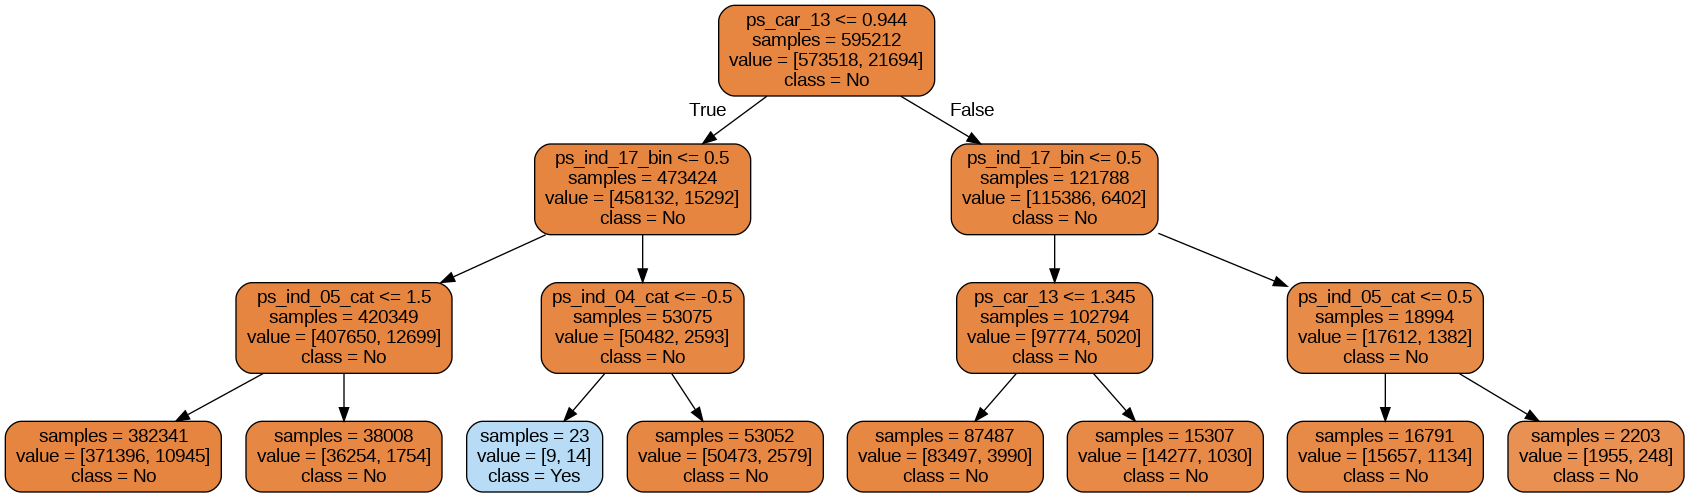

In [20]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)